In [119]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import pandas_datareader.data as web

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, roc_auc_score, log_loss

import matplotlib.pyplot as plt
import seaborn as sns


## Credit Risk Modeling Under Basel III / IFRS 9

The **Expected Credit Loss (ECL)** is defined as:

$$
\text{ECL} = \text{PD} \times \text{LGD} \times \text{EAD}
$$
Where:

- **PD (Probability of Default):** the likelihood that a borrower defaults within a given horizon (usually 1 year).  
- **LGD (Loss Given Default):** the fraction of exposure lost if default occurs, typically **40–60%** for unsecured loans.  
- **EAD (Exposure at Default):** the outstanding loan amount at the time of default.


### 1.1 Getting the Data: Home Credit Dataset

We use a sample of the **Home Credit Default Risk dataset** to estimate PD with logistic regression.  
For LGD and EAD, we assign synthetic values to simulate realistic scenarios.

In [5]:
# Load Home Credit data
df = pd.read_csv('./data/application_train.csv')
# Getting a sample of the data for training the model
df_sample = df.sample(n=5000, random_state=42)

#### 1.2 Estimating Probability of Default (PD)

We estimate **PD** using logistic regression, a standard method for default prediction.  
Each borrower will then have:
- PD (from the model),
- LGD (synthetic),
- EAD (synthetic),

allowing us to compute **ECL** at the individual level and aggregate by credit rating or sector.


In [7]:
# Training the logistic regression model:
scaler = StandardScaler()
features = df_sample.select_dtypes(include='number').drop(['TARGET'], axis=1).fillna(0)
X_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, df_sample['TARGET'], test_size=0.33, random_state=123)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

df_sample['PD'] = model.predict_proba(X_scaled)[:, 1]

In [9]:
# Predict probabilities
y_pred_proba = model.predict_proba(X_train)[:, 1]

# Log loss (cross-entropy)
loss = log_loss(y_train, y_pred_proba)
print(f"Log Loss: {loss:.4f}")

# AUC-ROC (classification quality)
auc = roc_auc_score(y_train, y_pred_proba)
print(f"AUC-ROC: {auc:.4f}")

Log Loss: 0.2416
AUC-ROC: 0.7778


In [11]:
# LGD = Loss Given Default, usually 40%-60% for unsecured
df_sample['LGD'] = np.random.uniform(0.4, 0.6, size=len(df_sample))

# EAD = Exposure at Default (loan amount)
df_sample['EAD'] = df_sample['AMT_CREDIT'] 

### 1.3 Computing Expected Credit Loss (ECL)

Now that we have estimated **PD** from logistic regression and assigned synthetic **LGD** and **EAD**, we can compute the **Expected Credit Loss** for each borrower.  

This involves multiplying borrower-level PD, LGD, and EAD, then aggregating across the portfolio to obtain the total ECL.  

And finally, we will group borrowers by **credit rating** to analyze ECL at a more aggregated level.


In [25]:
df_sample['ECL'] = df_sample['PD'] * df_sample['LGD'] * df_sample['EAD']
# Aggregate total ECL
total_ecl = df_sample['ECL'].sum()
print(f"Total portfolio ECL: {total_ecl:,.0f}")

Total portfolio ECL: 121,405,212


In [120]:
# PD bands (in decimals)
bins = [0, 0.001, 0.005, 0.01, 0.03, 0.07, 0.20, 1.0]
labels = ["AAA","AA","A","BBB","BB","B","CCC"]
df_sample["Credit_Rating"] = pd.cut(df_sample["PD"], bins=bins, labels=labels, include_lowest=True, right=True)

In [121]:
# Aggregates by rating
agg_rating = (df_sample.groupby("Credit_Rating", observed=True)
                .agg(EAD_sum=("EAD","sum"),
                     ECL_sum=("ECL","sum"),
                     PD_avg=("PD","mean"),
                     LGD_avg=("LGD","mean"))
                .sort_index())
agg_rating["ECL_rate_%"] = 100 * agg_rating["ECL_sum"] / agg_rating["EAD_sum"]


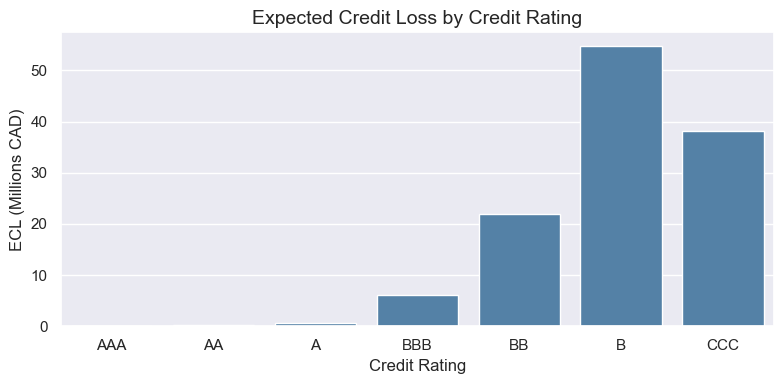

In [122]:
sns.set_theme(style="darkgrid")

# Plot ECL by Credit Rating
plt.figure(figsize=(8,4))
sns.barplot(x=agg_rating.index, y=agg_rating["ECL_sum"]/1e6, color="steelblue")
plt.ylabel("ECL (Millions CAD)")
plt.xlabel("Credit Rating")
plt.title("Expected Credit Loss by Credit Rating", fontsize=14)
plt.tight_layout()
plt.show()


## 2. Market Risk

Now, we analyze market risk for the portfolio using historical market data.  

We will:  
1. Calculate **Value at Risk (VaR)** and **Conditional Value at Risk (CVaR/ES)**.  
2. Compute **rolling volatility** to capture time-varying risk.  
3. Simulate **market downturn scenarios**.  
4. Visualize risk metrics over time for portfolio monitoring.


### 2.1 Getting the Data

For market risk analysis, we selected three representative instruments:

- **LQD** – iShares Investment Grade Corporate Bond ETF  
  Captures corporate bond risk and credit-sensitive fixed income exposure.

- **TLT** – iShares 20+ Year Treasury Bond ETF  
  Serves as a proxy for risk-free rates and interest rate exposure.

- **^GSPTSE** – S&P/TSX Composite Index (Canada)  
  Represents the Canadian equity market and captures equity risk in the portfolio.


In [39]:
tickers = ['LQD', 'TLT', '^GSPTSE']

# Download historical data
data = yf.download(tickers, start='2015-08-01', end='2025-07-31', auto_adjust=True)

# Extract 'Close' prices
close_prices = data['Close']
close_prices.columns.name = None

# Compute daily returns
daily_returns = close_prices.pct_change(fill_method=None).dropna()

# Data Preview
daily_returns.head()

[*********************100%***********************]  3 of 3 completed


,LQD,TLT,^GSPTSE
Date,,,
2015-08-05,-0.003889,-0.007506,0.000821
2015-08-06,0.001909,0.008878,-0.006695
2015-08-07,0.003463,0.013118,-0.007164
2015-08-10,-0.003970,-0.012385,0.011445
2015-08-11,0.004159,0.015879,-0.003574


### 2.3 Value at Risk (VaR) & Conditional Value at Risk (CVaR / Expected Shortfall)

**Value at Risk (VaR)** estimates the maximum potential loss over a given horizon at a specified confidence level:

$
VaR_\alpha = \text{percentile}_{1-\alpha}(R_t)
$

**Conditional Value at Risk (CVaR)**, also called **Expected Shortfall (ES)**, measures the expected loss **beyond the VaR threshold**:

$
CVaR_\alpha = E[R_t \mid R_t \leq VaR_\alpha]
$

Where:  
- $R_t$ = daily portfolio return  
- $\alpha$ = confidence level (e.g., 99%)


In [43]:
# Assuming equal weights for simplicity
portfolio_returns = daily_returns.sum(axis=1)

# Confidence level
alpha = 0.99

# 1-day 99% Value at Risk (VaR)
VaR_99 = np.percentile(portfolio_returns, (1 - alpha) * 100)

# 1-day 99% Conditional VaR (CVaR / Expected Shortfall)
CVaR_99 = portfolio_returns[portfolio_returns <= VaR_99].mean()

print(f"1-day 99% VaR: {VaR_99:.4f}")
print(f"1-day 99% CVaR / ES: {CVaR_99:.4f}")

1-day 99% VaR: -0.0459
1-day 99% CVaR / ES: -0.0693


### 2.4 Rolling Volatility & Stress Scenarios

To understand how portfolio risk changes over time, we compute **rolling volatility** and **rolling VaR / CVaR**.  


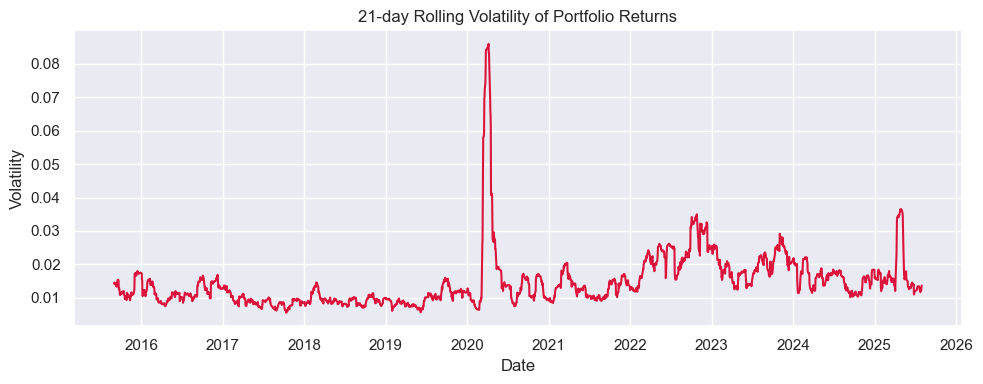

In [45]:
rolling_window = 21  # 1 month
rolling_vol = portfolio_returns.rolling(window=rolling_window).std()

plt.figure(figsize=(10,4))
sns.lineplot(data=rolling_vol, color="crimson")
plt.title(f"{rolling_window}-day Rolling Volatility of Portfolio Returns")
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


## Chapter 3: Stress Testing with STLFSI

Stress testing evaluates how the portfolio performs under extreme market conditions.  
Here, we use the **St. Louis Fed Financial Stress Index (STLFSI)**, which measures the level of stress in the U.S. financial system.

- High STLFSI values indicate **high market stress**.
- Low or negative values indicate **normal or calm conditions**.

We will:
1. Identify high-stress periods.
2. Quantify market and credit risk during these periods.
3. Visualize potential losses under stress scenarios.


### 3.1 Defining Stress Periods

In [56]:
# Load St. Louis Fed Financial Stress Index (STLFSI) data
start = datetime.datetime(2015, 8, 1)
stlfs_index = web.DataReader('STLFSI4', 'fred', start=start)

# Merge with portfolio returns
portfolio_returns = daily_returns.sum(axis=1).to_frame('Portfolio')
returns_stress = portfolio_returns.join(stlfs_index, how='inner')

# Define high stress periods (top 10% STLFSI)
high_stress = returns_stress['STLFSI4'] > returns_stress['STLFSI4'].quantile(0.9)

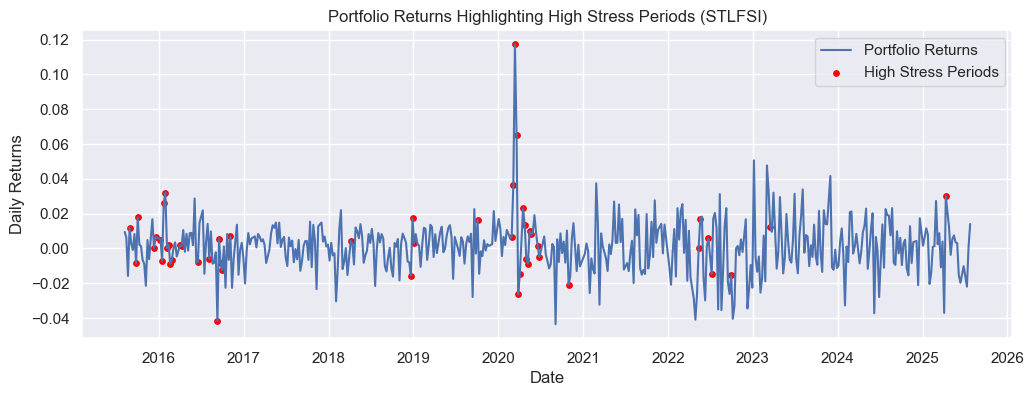

In [57]:
plt.figure(figsize=(12,4))
plt.plot(returns_stress['Portfolio'], label='Portfolio Returns')
plt.scatter(returns_stress.index[high_stress], 
            returns_stress['Portfolio'][high_stress],
            color='red', s=15, label='High Stress Periods')
plt.title("Portfolio Returns Highlighting High Stress Periods (STLFSI)")
plt.xlabel("Date")
plt.ylabel("Daily Returns")
plt.legend()
plt.show()


### 3.2 Portfolio Performance in Stress Periods

In [51]:
# Overall average daily return
avg_portfolio = returns_stress['Portfolio'].mean()

# Average return during high stress
avg_market_loss_stress = returns_stress['Portfolio'][high_stress].mean()

print(f"Average portfolio daily return (all periods): {avg_portfolio:.4f}")
print(f"Average portfolio daily return during high stress: {avg_market_loss_stress:.4f}")


Average portfolio daily return (all periods): 0.0011
Average portfolio daily return during high stress: 0.0055


In [53]:
stress_impact = avg_market_loss_stress / avg_portfolio
print(f"Stress impact factor: {stress_impact:.2f}")

Stress impact factor: 4.91


In [58]:
# Stress-testing Credit Risk (ECL)
# Assuming ECL increases by 50% during high stress
stress_factor = 1.5
df_sample['ECL_stressed'] = df_sample['ECL'] * stress_factor
total_ecl_stressed = df_sample['ECL_stressed'].sum()
print(f"Total stressed portfolio ECL: {total_ecl_stressed:,.0f}")

Total stressed portfolio ECL: 182,107,818


In [60]:
print(f"Total baseline ECL: {total_ecl:,.0f}")
print(f"Total stressed ECL: {total_ecl_stressed:,.0f}")
increase_pct = (total_ecl_stressed - total_ecl) / total_ecl * 100
print(f"Increase under stress: {increase_pct:.2f}%")


Total baseline ECL: 121,405,212
Total stressed ECL: 182,107,818
Increase under stress: 50.00%


In [83]:
# Define stress scenarios
stress_scenarios = {
    "Moderate": {"market_scale": 1.2, "credit_factor": 1.2},
    "High": {"market_scale": 1.5, "credit_factor": 1.5}
}

scenario_results = {}

for scenario, params in stress_scenarios.items():
    # Market risk adjustment: scale returns
    returns_stress = daily_returns * params["market_scale"]
    portfolio_returns = returns_stress.mean(axis=1)  # simple equally-weighted portfolio

    # Calculate VaR and CVaR
    var_99 = np.percentile(portfolio_returns, 1)
    cvar_99 = portfolio_returns[portfolio_returns <= var_99].mean()

    # Credit risk adjustment: scale ECL
    df_sample[f"ECL_{scenario}"] = df_sample['ECL'] * params["credit_factor"]
    total_ecl_stress = df_sample[f"ECL_{scenario}"].sum()

    scenario_results[scenario] = {
        "1-day 99% VaR": var_99,
        "1-day 99% CVaR": cvar_99,
        "Total ECL": total_ecl_stress
    }

# Display results
scenario_results_df = pd.DataFrame(scenario_results).T
scenario_results_df


,1-day 99% VaR,1-day 99% CVaR,Total ECL
Moderate,-0.018362,-0.027701,1.456863e+08
High,-0.022952,-0.034626,1.821078e+08


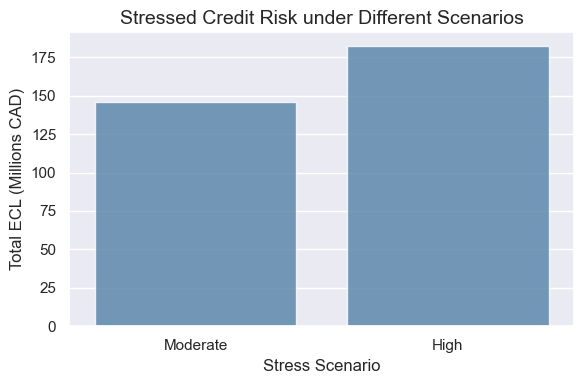

In [117]:
# Bar plot for Total ECL under different stress scenarios
plt.figure(figsize=(6,4))
sns.barplot(
    x=scenario_results_df.index,
    y=scenario_results_df["Total ECL"]/1e6,  # convert to millions
    color="steelblue",  # single color avoids the warning
    alpha=0.8
)
plt.ylabel("Total ECL (Millions CAD)")
plt.xlabel("Stress Scenario")
plt.title("Stressed Credit Risk under Different Scenarios", fontsize=14)
plt.tight_layout()
plt.show()



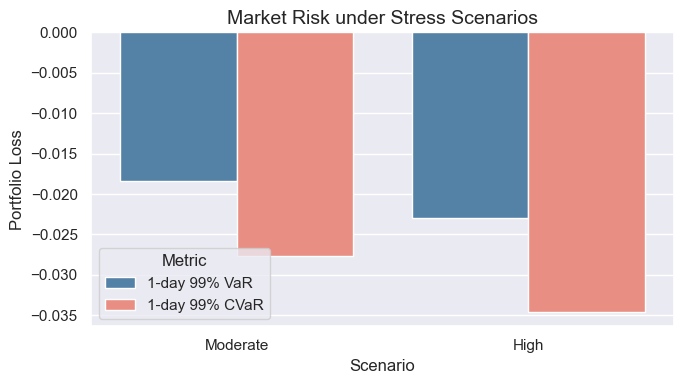

In [85]:
# Bar plot for 1-day 99% VaR and CVaR
market_risk_df = scenario_results_df[["1-day 99% VaR", "1-day 99% CVaR"]].copy()
market_risk_df = market_risk_df.reset_index().melt(id_vars="index", var_name="Metric", value_name="Loss")
market_risk_df.rename(columns={"index": "Scenario"}, inplace=True)

plt.figure(figsize=(7,4))
sns.barplot(
    x="Scenario",
    y="Loss",
    hue="Metric",
    data=market_risk_df,
    palette=["steelblue", "salmon"]
)
plt.ylabel("Portfolio Loss")
plt.title("Market Risk under Stress Scenarios", fontsize=14)
plt.tight_layout()
plt.show()


In [111]:
rho = 0.2  # correlation between market and credit risk

# Calculate aggregated portfolio risk for each scenario
scenario_results_df["Total Portfolio Risk"] = 0.0

for scenario in scenario_results_df.index:
    total_ecl = scenario_results_df.loc[scenario, "Total ECL"]
    ES_99 = scenario_results_df.loc[scenario, "1-day 99% CVaR"]
    
    # Aggregated risk formula
    total_risk = ((total_ecl**2 + ES_99**2 + 2 * rho * total_ecl * ES_99)**0.5)
    
    scenario_results_df.loc[scenario, "Total Portfolio Risk"] = total_risk


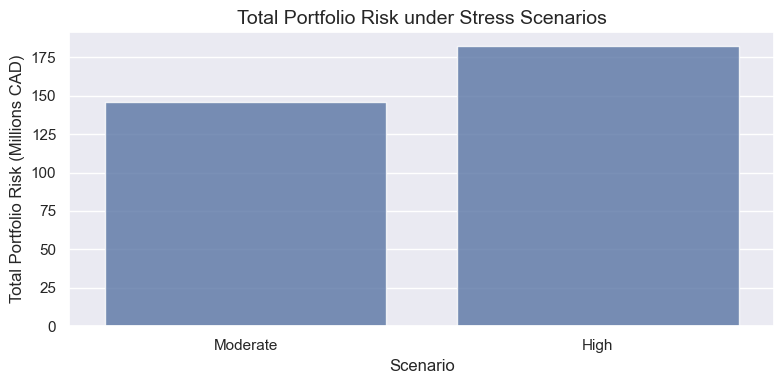

In [123]:
plt.figure(figsize=(8,4))
sns.barplot(
    x=scenario_results_df.index,
    y=scenario_results_df["Total Portfolio Risk"]/1e6,  
    alpha=0.8
)

plt.ylabel("Total Portfolio Risk (Millions CAD)")
plt.xlabel("Scenario")
plt.title("Total Portfolio Risk under Stress Scenarios", fontsize=14)
plt.tight_layout()
plt.show()
